<a href="https://colab.research.google.com/github/jear2412/MCMC/blob/master/BlackPlague-SIR-BiAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#black plague sir, beta known

import numpy as np
import scipy
import scipy.stats
import scipy.integrate
from scipy.integrate import odeint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from numba import jit
from matplotlib import cm
import emcee
import pystan
import time
#import pytwalk as twalk #upload it 

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

sns.set()

In [1]:
pip install emcee

     |████████████████████████████████| 51kB 3.6MB/s 


In [4]:

def Analysis(x):
    mean=np.mean(x,0)
    median=np.median(x,0)
    var=np.var(x,0)

    ess=np.zeros( x.shape[1])
    for i in range( x.shape[1] ):
      ess[i]=tfp.mcmc.effective_sample_size(  x[:,i] , filter_beyond_positive_pairs=True)
    
    mess=np.min(ess)

    summary= {
        "Mean": mean,
        "Median":median,
        "Variance": var,
        "mVar": var/ess,
        "ess": ess,
        "mess":mess, #min ess

        }
    return summary

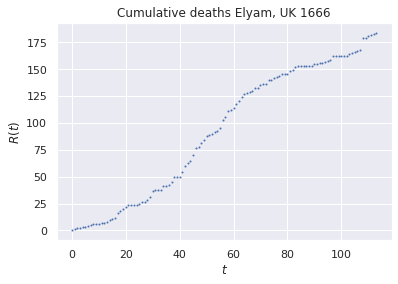

In [5]:

''' Second black plague outbreak in Eyam, UK 
    June 19, 1666 to Nov 1, 1666 (Massel et al 2004)
    114 days
    The village had been quarantined so the population
    is fixed to N=261. 
    
    States: 
        S(t): susceptible
        I(t): infected
        R(t): removed
        N=S(t)+I(t)+R(t)
    obs: once you get the plague you never recover, you die 
    
    '''
    
N=261 #Total population   

def SIR( X, t,  alpha, I0  ):
    dSdt= -beta* X[0] * X[1]
    dIdt= beta*X[0] * X[1]- alpha*X[1]
    dRdt= alpha*X[1]
    return np.array( [   dSdt, dIdt, dRdt   ]   )
    

data = pd.read_csv("Eyam_time_SIR.csv") 
data.index
y=np.append(0, pd.Series.to_numpy(data.iloc[:, 3])) #cumulative deaths 
x=pd.Series.to_numpy(data.iloc[ 111:114 , 2 ])
n=len(y)        
ts=np.arange(0,len(y),1 )



plt.scatter( ts,y, s=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'$R(t)$' )
plt.title('Cumulative deaths Elyam, UK 1666')
plt.savefig('plotcumdeaths.png', dpi=500)
plt.show()



In [6]:
#beta is fixed
pbeta=0.000679 #PTHMC
tbeta=0.000692 #twalk
mcbeta= 0.000685 #emcee



In [7]:

#beta is fixed!!!

def logprior( Theta):
    alpha=Theta[0]
    I0=Theta[1]
    if( alpha>0 and I0>=1 and I0<=N  ):
         a= -alpha-beta+I0*np.log( 5/N )+(N-I0)*np.log( 1- 5/N   )
         b=scipy.special.loggamma(N+1)- scipy.special.loggamma(I0+1)- scipy.special.loggamma(N-I0+1)
         return a+b
    else:
         return -np.inf
    
    
def logL(Theta):
    alpha=Theta[0]
    I0=Theta[1]
    n=len(y)
    X0=np.array( [N-I0, I0, 0] )
    Xt = odeint( SIR, X0, ts, args=(alpha,I0,))  
    St=Xt[:,0]
    St[St<0]=0
    It= Xt[:,1]
    It[It<0]=0
    Rt=Xt[:,2]
    Rt[Rt>261]=261
    ll=0
    ll=ll+np.log( It[n-2]/N +1e-300 )+(N-1)*np.log( 1- It[n-2]/N    )+N*np.log( 1- It[n-1]/N  )
    ll=ll+ np.sum(y[1:n]* np.log( Rt[1:] /N ))+np.sum( (N-y[1:])  *np.log(   1- Rt[1:]/N +1e-300 ))
    return ll
    

def lpost(Theta): #energy function
    alpha=Theta[0]
    I0=Theta[1]
    if( alpha>0 and I0>=1 and I0<=N  ):
         return -logprior(Theta)-logL(Theta) 
    else:
         return np.inf
  

def bifpoints(f, lb, upb, m=100):

    '''
      Function to plot a bivariate posterior
      f is the objective function to be plotted
      args are the arguments of f as a list
      lb: array of lower bounds
      upb:array of upper bounds
       '''
       
    xx = np.linspace(lb[0], upb[0], m)
    yy = np.linspace(lb[1], upb[1], m)
    xx, yy = np.meshgrid(xx, yy)
    Z = np.zeros(shape=[m, m])
    temp=np.zeros(2)
    for i in range( m ):
        for j in range( m ):
            temp=np.array( [xx[i][j], yy[i][j]] )
            Z[i][j] = f( temp )
    return xx,yy,Z 

def pContour(xx,yy,Z,c=100):
    plt.contour( xx, yy, Z, c, colors='b' )
    plt.xlabel( r'$\theta_1$' )
    plt.ylabel( r'$\theta_2$' )
    plt.title( r'Objective Function Contours' )
    plt.show()

def pSurface(xx,yy, Z):
    fig = plt.figure()
    ax = plt.axes( projection='3d' )
    ax.plot_surface( xx, yy, Z, cmap='Spectral')
    # ax.contour3D(xx, yy, Z, 30, cmap='binary')
    ax.set_xlabel( r'$\theta_1$' )
    ax.set_ylabel( r'$\theta_2$' )
    ax.set_zlabel( r'$Posterior Surface' )
    ax.view_init( 60, 35 )
    fig






In [8]:
beta=tbeta
xx,yy,Z= bifpoints(f= lpost, lb=np.array([ 0.010/2, 1 ])  , upb= np.array([ .15 , 15  ])  , m=100 )



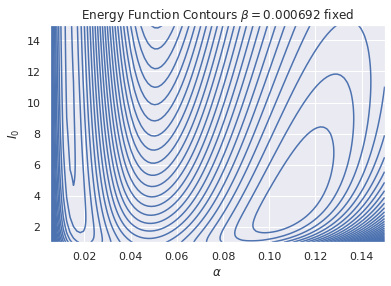

In [9]:
plt.contour( xx, yy, Z, 30, colors='b' )
plt.xlabel( r'$\alpha$')
plt.ylabel( r'$I_0$' )
plt.title( r'Energy Function Contours '+r'$\beta=$'+str(beta)+' fixed' )
plt.show()




In [10]:
from scipy import optimize

#two maps
map1=optimize.minimize( lpost ,  np.array([ 0.11, 4])  ,method='bfgs', tol=1e-5)
print('map1: ', map1['x'])
map2=optimize.minimize( lpost ,  np.array([ 0.01, 7.5])  ,method='bfgs', tol=1e-5)
print('map2: ', map2['x'])

map1:  [0.11021991 3.77402529]
map2:  [ 0.01339937 11.78559197]


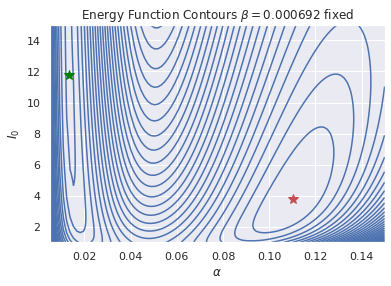

In [28]:
#bivariate plot with maps


plt.plot( map1['x'][0], map1['x'][1], '*', color='r', markersize=10   )
plt.plot( map2['x'][0], map2['x'][1], '*', color='green', markersize=10   )
plt.contour( xx, yy, Z, 30, colors='b' )
plt.xlabel( r'$\alpha$')
plt.ylabel( r'$I_0$' )
plt.title( r'Energy Function Contours '+r'$\beta=$'+str(beta)+' fixed' )
plt.savefig( 'mapcontours.pdf', dpi=500  )
plt.show()






In [12]:
def SolveSIR(theta):
  #Solve SIR for given parameter theta
  alpha=theta[0]
  I0=theta[1]
  X0=np.array( [N-I0, I0, 0] )
  temp=odeint( SIR, X0, ts, args=(alpha,I0,))
  return temp


In [18]:

temp1=SolveSIR( map1['x'] )
temp2=SolveSIR( map2['x'] )
temp3=SolveSIR( np.array([0.013785, 9.774])   )

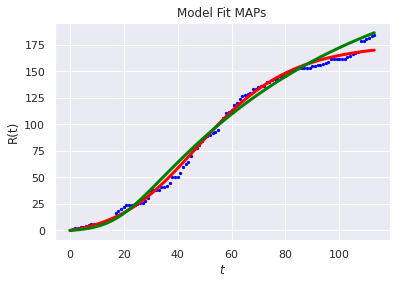

In [24]:

# R(t)

plt.plot(temp1[:,2] , color='red', linewidth=3 )
plt.plot(temp2[:,2] , color='green', linewidth=3  )
plt.scatter(ts,y, s=5, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'Model Fit MAPs' )
plt.savefig( 'map1.pdf', dpi=500  )
plt.show()

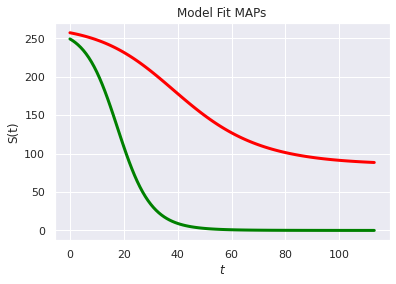

In [25]:
#St
plt.plot(temp1[:,0] , color='red', linewidth=3 )
plt.plot(temp2[:,0] , color='green', linewidth=3  )
plt.xlabel( r'$t$' )
plt.ylabel( r'S(t)' )
plt.title( 'Model Fit MAPs' )
plt.savefig( 'mapSt.pdf', dpi=500  )
plt.show()

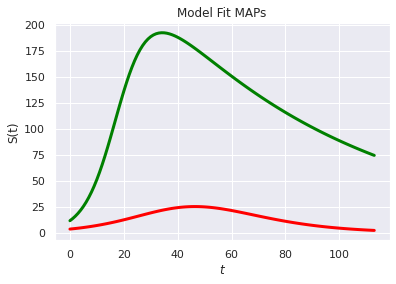

In [26]:
#It

plt.plot(temp1[:,1] , color='red', linewidth=3 )
plt.plot(temp2[:,1] , color='green', linewidth=3  )
plt.xlabel( r'$t$' )
plt.ylabel( r'S(t)' )
plt.title( 'Model Fit MAPs' )
plt.savefig( 'mapIt.pdf', dpi=500  )
plt.show()


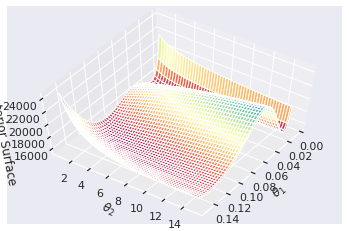

In [27]:
fig = plt.figure()
ax = plt.axes( projection='3d' )
ax.plot_surface( xx, yy, Z, cmap='Spectral')
# ax.contour3D(xx, yy, Z, 30, cmap='binary')
ax.set_xlabel( r'$\theta_1$' )
ax.set_ylabel( r'$\theta_2$' )
ax.set_zlabel( r'$Posterior Surface' )
ax.view_init( 60, 35 )
